In [1]:

# %%
# ## Getting Started
from pathlib import Path
from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import numpy as np
import matplotlib.pyplot as plt
import flopy
import pandas as pd
import shutil
import pickle
import subprocess
import os
# %% [markdown]

# %%

In [2]:
################### Model Parameters   ##############################
my_params = {}
my_params['name'] = 'test_wasaga_2'
## mt3dGcg
cclose=my_params['cclose'] = 1e-5
## RCT

my_params['hk'] = 6.9
my_params['vk'] = 0.1

my_params['porosity'] = 0.35
my_params['sy'] = 0.33
my_params['ss'] = 0.0002
my_params['la'] = 0.2
my_params['trpt'] = 0.1
my_params['trpv'] = 0.1
my_params['dmcoef'] = 3.7E-10 ####
my_params['sconc'] = 0.01

#Species ID
sp_ID = {}
#sp_ID['Cl-'] = 1
sp_ID['SRP'] = 1
my_params['sp_ID'] = sp_ID

#Species Name
sp_name = {}
#sp_name[1] = 'Cl-'
sp_name[1] = 'SRP'
my_params['sp_name'] = sp_name


## P lens
my_params['perlen'] = [1]+[30,92,31,212]*25 +[365]*5+[365*5]*5+[365*4]+[185,30,30,120]


## Wel data
wel_data = {}
#last_wel_id = len(my_params['perlen'])-1
for y in range(25):
    p = (y)*4 +2
    wel_data[p] = [[50,0,15,0.0075]]
    p += 1
    wel_data[p] = [[50,0,15,0.075]]
    p += 1
    wel_data[p] = [[50,0,15,0.0075]]
    p += 1
    wel_data[p] = [[50,0,15,0.0]]
    p += 1

wel_data[p] = [[50,0,15,0]]
my_params['wel_data'] = wel_data


# Mt3dSsm 
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict()

for y in range(25):
    p = (y)*4 +2
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
ssm_data[p] = [(50, 0, 15, 0.0, itype['WEL'])]
my_params['ssm_data'] = ssm_data


#Mt3dBtn
mixelm=my_params['mixelm'] = 0 # HMOC
my_params['isothm'] = 3 # Langmuir
my_params['sp1'] = 0.0001 ##  0.1 mg/L  => 1e5 ug/m3
my_params['sp2'] = 0.0001  ##  maximum soil adsorption value = 100 ug/g => 1e5 ug/kg

# Rch
my_params['rech'] = 0.5/365 #0.5/365 ## 500mm/year

# dt0
my_params['dt0'] = 0.1
################################################################

base_model_my_params = my_params

In [3]:
my_params['sp1'] = 0.0002
my_params['la'] = 5
my_params['hk'] = 6.9
base_model_my_params = my_params.copy()

my_params['vk'] = 0.1
trpv=my_params['trpv'] = 0.01

In [4]:
# bed size 10x10
# row: 25-35 (1m), col 12-17 (2m)
#  50 cells

In [5]:
mytop =np.loadtxt('_imports/top')
mybot = np.loadtxt('_imports/bot')
myibound = np.loadtxt('_imports/ibound')
mystrt = np.loadtxt('_imports/strt')
myicbund = np.loadtxt('_imports/icbund')

In [6]:
mytop = np.tile(mytop.reshape([74,1,110]),(1,60,1))
mybot = np.tile(mybot.reshape([74,1,110]),(1,60,1))
myibound= np.tile(myibound.reshape([74,1,110]),(1,60,1))
mystrt = np.tile(mystrt.reshape([74,1,110]),(1,60,1))
myicbund = np.tile(myicbund.reshape([74,1,110]),(1,60,1))

In [7]:
# mytop = np.tile(mytop.reshape([74,1,110]),(1,1,1))
# mybot = np.tile(mybot.reshape([74,1,110]),(1,1,1))
# myibound= np.tile(myibound.reshape([74,1,110]),(1,1,1))
# mystrt = np.tile(mystrt.reshape([74,1,110]),(1,1,1))
# myicbund = np.tile(myicbund.reshape([74,1,110]),(1,1,1))

In [8]:
# ## Import
Lx = 150
Lz = 1
nlay = 74
nrow = 60
ncol = 110
delr = np.concatenate([np.repeat(2,25),np.repeat(1,70),np.repeat(2,15)])
delc = 1.0
delv = mytop[:,0] - mybot[:,0]


In [9]:
# ## Workspace


import os
from datetime import datetime


myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
#name =my_params['name']
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
workspace = temp_dir
os.makedirs(Path(workspace) / '_output')
swt = flopy.seawat.Seawat(name, exe_name="swtv4", model_ws=workspace)

In [16]:
swt.exe_name

'/Users/b/.local/share/flopy/bin/swtv4'

In [10]:


##

import os
import platform
import subprocess

def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(workspace)


In [11]:
# %%
def create_time_table():
    time_table = pd.DataFrame()

    perlen = pd.Series(my_params['perlen'])
    perlen.index = perlen.index+1

    time_table['perlen'] = perlen
    time_table['Time'] = time_table['perlen'].cumsum()

    #time_table = pd.DataFrame()
    for key,value in wel_data.items():
        key
        time_table.loc[key,'wel_data'] = value[0][3]

    #time_table = pd.DataFrame()
    for key,value in ssm_data.items():
        key
        time_table.loc[key,'ssm'] = value[0][3]
    return time_table


In [12]:

# ## DIS

# %%
ipakcb = 53

# %%

perlen = my_params['perlen']
nper = len(perlen)
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))



# %%
dis = flopy.modflow.ModflowDis(
    swt,
    nlay,
    nrow,
    ncol,
    nper=nper,
    delr=delr,
    delc=delc,
    laycbd=0,
    top=182.2,
    botm=mybot,
    perlen=perlen,
    nstp=nstp, #Number of time steps in each stress period
    steady = steady
)

## WEL

In [15]:

# #last_wel_id = len(my_params['perlen'])-1

# ## Wel data
# wel_data = {}
# # Mt3dSsm 
# ssm_data = {}
# for per in range(nper):
#     wel_data[per]= []
#     ssm_data[per] = []


# for row in range(25,35+1):
#     for col in range(12,17+1):
#         for y in range(25):

#             p = (y)*4 +2
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1


#             wel_data[p].append([50,row,col,0.5/50])




# itype = flopy.mt3d.Mt3dSsm.itype_dict()



# for row in range(25,35+1):
#     for col in range(12,17+1):
#         for y in range(25):
#             p = (y)*4 +2
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#         ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))


# my_params['ssm_data'] = ssm_data



## RCH

In [13]:
rch_dict = {}

rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
rch_dict[0] = rch_array

rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
#rch_array[int(nrow/2),int(ncol/2)] = 0.51/delr/delc
#rch_array[int(nrow/2),int(ncol/3)] = 0.51/delr/delc

for row in range(25,35+1):
    for col in range(12,17+1):
        rch_array[row,col] = 0.51/10/10
        rch_array[row,col] = 0.51/10/10

rch_dict[1] = rch_array 


rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
rch_dict[int(25*4+1)] = rch_array




In [14]:
crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)
crch_dict = {}
crch_dict[0] = crch_array

crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)

# crch_array[int(nrow/2),int(ncol/2)] =5000
# crch_array[int(nrow/2),int(ncol/3)] =5000

for row in range(25,35+1):
    for col in range(12,17+1):
        crch_array[row, col] =3000
        crch_array[row, col]= 3000


crch_dict[1] = crch_array


crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)
crch_dict[int(25*4+1)] = crch_array



In [15]:

bas = flopy.modflow.ModflowBas(swt, myibound, mystrt)


lpf = flopy.modflow.ModflowLpf(swt, hk=my_params['hk'], vka=my_params['vk'],
                            ss= my_params['ss'],sy=my_params['sy'],
                            ipakcb=ipakcb,laytyp=1)

pcg = flopy.modflow.ModflowPcg(swt, hclose=1e-4)


In [19]:


stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]

# OC - Output Control Option
oc = flopy.modflow.ModflowOc(
    swt,
    stress_period_data= stress_period_data,
    compact=True,
)

# ## Well

# wel_data = my_params['wel_data']
# wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

# # ModflowRch

# rch = flopy.modflow.ModflowRch(model = swt, rech = my_params['rech'])

rch = flopy.modflow.ModflowRch(model = swt, rech = rch_dict)

# # ## SSM
# ssm_data = my_params['ssm_data']



# ## BTN

#timprs = my_params['perlen'][:5]*5 +np.arange(365,np.sum(my_params['perlen']),5*355).tolist()
timprs = np.cumsum(my_params['perlen'])
timprs = [1]




btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=len(timprs),
    timprs=timprs,
    prsity=my_params['porosity'],
    sconc=my_params['sconc'], # starting concentration
    ifmtcn=0,
    chkmas=False,
    nprobs=10,
    nprmas=10,
    dt0=my_params['dt0'],  # The user-specified initial transport step size
    ttsmult=1.1,
    mxstrn = 50000,
    icbund = myicbund
)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=my_params['mixelm'],percel=0.4,mxpart=200000,nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=my_params['la'], trpt=my_params['trpt'], 
                        trpv=my_params['trpv'], 
                        dmcoef=my_params['dmcoef'])
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=50, mxiter=1, isolve=2, cclose=my_params['cclose'])

ssm = flopy.mt3d.Mt3dSsm(swt, crch=crch_dict)

# %% [markdown]
# ## RCT


rct = flopy.mt3d.Mt3dRct(model=swt, isothm=my_params['isothm'],sp1=my_params['sp1'],sp2=my_params['sp2'],igetsc=0,rhob= 1.65E+09)





# %%
#Pht3d
#phc = flopy.mt3d.Mt3dPhc(swt,mine=[1],ie=[1],surf=[1],mobkin=[1],minkin=[1],surfkin=[1],imobkin=[1])
#phc.write_file()

# %% [markdown]
# # Write File

Util2d rech_1: locat is None, but model does not support free format and how is internal... resetting how = external
Util2d rech_2: locat is None, but model does not support free format and how is internal... resetting how = external
Util2d rech_102: locat is None, but model does not support free format and how is internal... resetting how = external
FloPy is using the following executable to run the model: ../../../../../../Users/b/.local/share/flopy/bin/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulti

PosixPath('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1221124821_wasaga_cn90pvpy/_output/_imports')

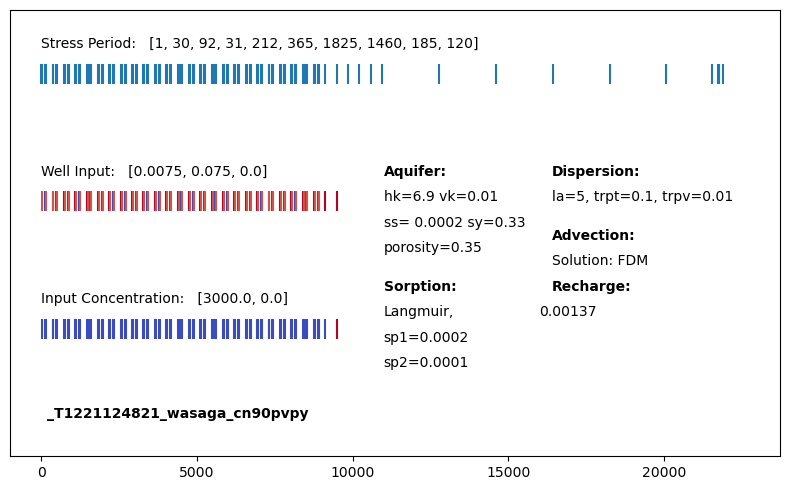

In [20]:


# %%
swt.write_input()

# %%


# %% [markdown]
# ## ################   Run      ########################

# %%

success, buff = swt.run_model(silent=False, report=True)
assert success, "SEAWAT did not terminate normally."

# %%  dump
swt.my_params = my_params
swt.delv =  delv
swt.delr = delr
pickle.dump( swt, open( Path(workspace) / '_output' / 'model.pickle',"wb" ) )

# %%


# %% [markdown]
# # Summarize Parameters

# %%

def plot_my_params():

    time_table = create_time_table()

    fig,ax = plt.subplots(figsize=(8,5))

    xs = time_table['Time']
    ax.scatter(xs,np.repeat(10,len(xs)),s=200,marker='|')
    ax.annotate('Stress Period:   {}'.format([n for n in time_table['perlen'].dropna().unique()]),(0,10.2))


    mask = time_table['wel_data'].isna()
    xs = time_table[~mask]['Time']
    ax.scatter(xs,np.repeat(9,len(xs)),s=200,marker='|',c=time_table[~mask]['wel_data'],cmap='coolwarm_r')
    ax.annotate('Well Input:   {}'.format([n for n in time_table['wel_data'].dropna().unique()]),(0,9.2))


    mask = time_table['ssm'].isna()
    xs = time_table[~mask]['Time']
    ax.scatter(xs,np.repeat(8,len(xs)),s=200,marker='|',c=time_table[~mask]['ssm'],cmap='coolwarm_r')
    ax.annotate('Input Concentration:   {}'.format([n for n in time_table['ssm'].dropna().unique()]),(0,8.2))


    ax.annotate('Aquifer:',(11000,9.2),weight="bold")
    ax.annotate(('hk={0:.3g} '.format(my_params['hk']) + 'vk={0:.3g}'.format(my_params['vk'])),(11000,9))
    ax.annotate('ss= {} sy={}'.format(my_params['ss'],my_params['sy']),(11000,8.8))
    ax.annotate('porosity={}'.format(my_params['porosity']),(11000,8.6))

    ax.annotate('Dispersion:',(16400,9.2),weight="bold")
    ax.annotate('la={}, trpt={}, trpv={}'.format(my_params['la'],my_params['trpt'],my_params['trpv']),(16400,9))


    ax.annotate('Advection:',(16400,8.7),weight="bold")
    d = {0:'FDM',3:'HMOC'}
    ax.annotate('Solution: {}'.format(d[my_params['mixelm']]),(16400,8.5))


    ax.annotate('Sorption:',(11000,8.3),weight="bold")
    d = {0:'No Sorption',1:'Linear',3:'Langmuir'}
    ax.annotate('{},'.format(d[my_params['isothm']]),(11000,8.1))
    if my_params['isothm']==1:
        ax.annotate('sp1={}'.format(my_params['sp1']),(11000,7.9))
        
    elif my_params['isothm']==3:
        ax.annotate('sp1={}'.format(my_params['sp1']),(11000,7.9))
        ax.annotate('sp2={}'.format(my_params['sp2']),(11000,7.7))
        


    ax.annotate('Recharge:',(16400,8.3),weight="bold")
    #d = {0:'No Sorption',1:'Linear'}
    ax.annotate('{0:.3g}'.format(my_params['rech']),(16000,8.1))


    ax.annotate('{}'.format(os.path.basename(os.path.normpath(workspace))),(200,7.3),weight="bold")

    ax.axes.get_yaxis().set_visible(False)
    plt.ylim(7,10.5)
    plt.xlim(-1000,65*365)
    plt.tight_layout()
    plt.savefig(Path(workspace) /'_output/_my_params.png')


## Run
plot_my_params()


# %% [markdown]
# ## JSON
# %%
import json

with open(Path(workspace) /'_output/my_params.json', 'w') as fp:
    json.dump(my_params,fp)

# %%


# %% [markdown]
# ## Time_Table



# %%
create_time_table().to_csv(Path(workspace) /'_output/time_table.csv')   
shutil.copytree('_imports',Path(workspace)/'_output/_imports',dirs_exist_ok =True)
#shutil.copyfile(__file__,Path(workspace) /'_output/{}'.format(os.path.basename(__file__)))

# %%


(172.2, 177.0)

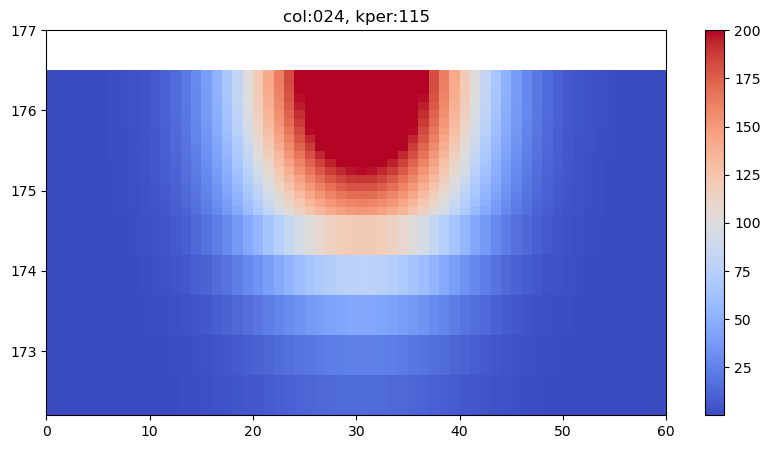

In [26]:

### read data
col = int(24)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

times = ucnobj.get_times()

    # Read the concentration data from the UCN file
    
concentration_array = ucnobj.get_data(totim=times[-1])# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

### plotting# ##
fig = plt.figure(figsize=(15, 4))
line = {"Column": col}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
plt.title('col:{:03}, kper:{:02}'.format(col,kper))
plt.gcf().set_size_inches(10,5)
plt.ylim(mybot.min(),177)

#plt.savefig(Path(workspace)/'_output/conc_{:02}.png'.format(kper))
#plt.clf()

##--------

(172.2, 177.0)

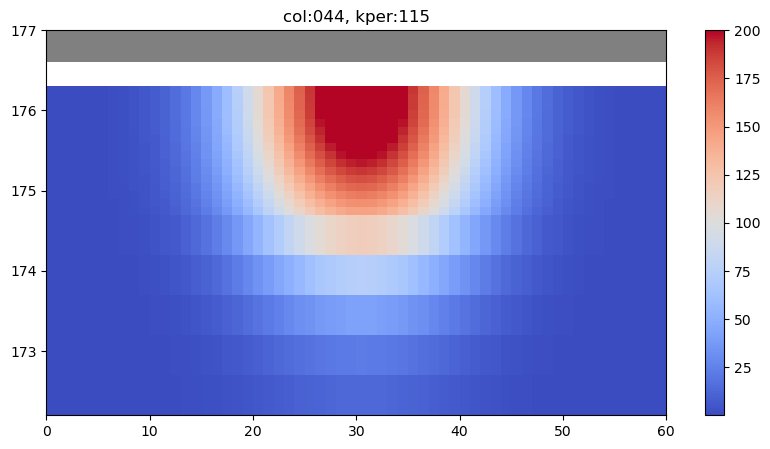

In [22]:

### read data
col = int(44)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

times = ucnobj.get_times()

    # Read the concentration data from the UCN file
    
concentration_array = ucnobj.get_data(totim=times[-1])# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

### plotting# ##
fig = plt.figure(figsize=(15, 4))
line = {"Column": col}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
plt.title('col:{:03}, kper:{:02}'.format(col,kper))
plt.gcf().set_size_inches(10,5)
plt.ylim(mybot.min(),177)

#plt.savefig(Path(workspace)/'_output/conc_{:02}.png'.format(kper))
#plt.clf()

##--------

(172.2, 177.0)

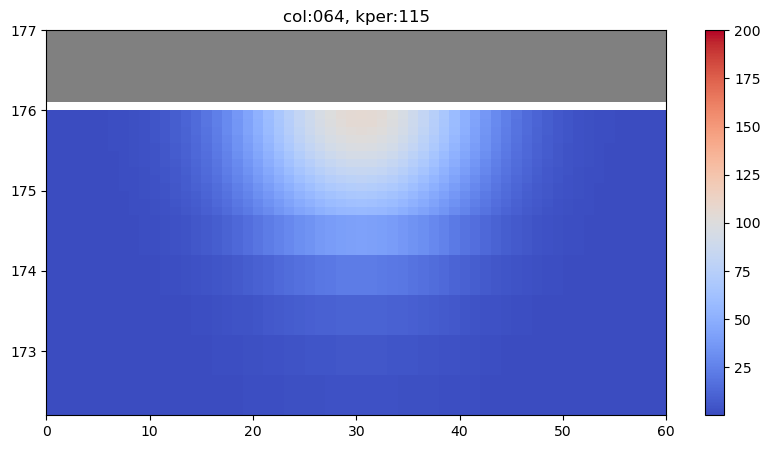

In [27]:

### read data
col = int(64)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

times = ucnobj.get_times()

    # Read the concentration data from the UCN file
    
concentration_array = ucnobj.get_data(totim=times[-1])# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

### plotting# ##
fig = plt.figure(figsize=(15, 4))
line = {"Column": col}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
plt.title('col:{:03}, kper:{:02}'.format(col,kper))
plt.gcf().set_size_inches(10,5)
plt.ylim(mybot.min(),177)

#plt.savefig(Path(workspace)/'_output/conc_{:02}.png'.format(kper))
#plt.clf()

##--------

12.4

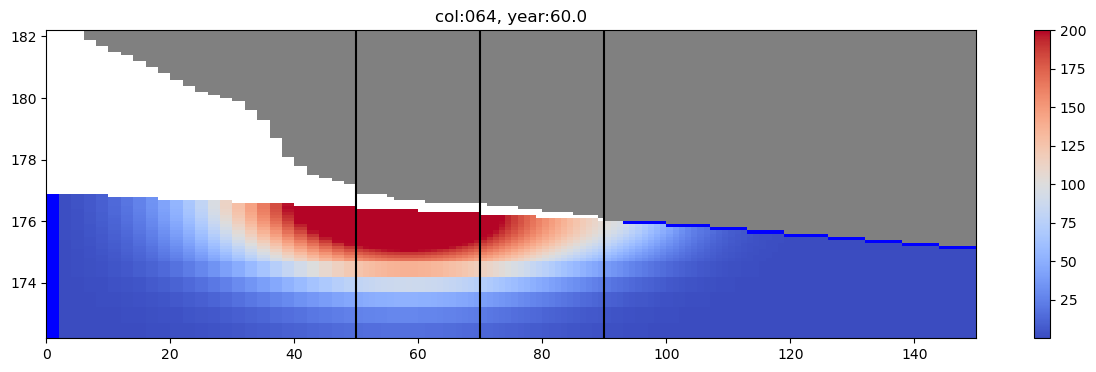

In [24]:
### read data
row = int(30)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

    # Read the concentration data from the UCN file
    
concentration_array = ucnobj.get_data(totim=times[-1])# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

### plotting# ##
fig = plt.figure(figsize=(15, 4))
line = {"Row": row}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
plt.title('col:{:03}, year:{:.1f}'.format(col,times[-1]/365))
plt.axvline(50,c='k')
plt.axvline(70,c='k')
plt.axvline(90,c='k')

#plt.savefig(Path(workspace)/'_output/conc_{:02}.png'.format(kper))
#plt.clf()

##--------

In [425]:
find_closest_value = lambda target_value: min(delr.cumsum(), key=lambda x: abs(target_value- x))
find_closest_value(140)

140

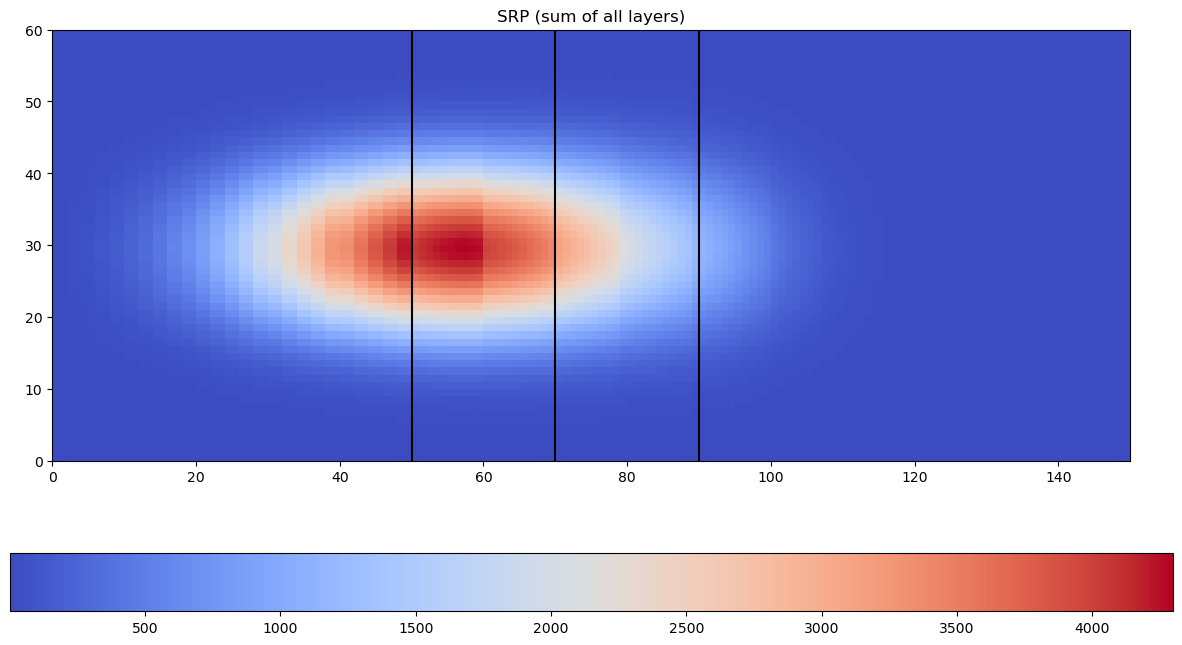

In [25]:
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace) / 'MT3D001.UCN')
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-1])  # get the concentration data for the last time step
conc[np.where(conc==1e30)] = 0
conc_sum = np.sum(conc, axis=0)
mapview = flopy.plot.PlotMapView(model=swt)
fig = mapview.plot_array(conc_sum,cmap='coolwarm')
plt.axvline(50,c='k')
plt.axvline(70,c='k')
plt.axvline(90,c='k')
plt.gcf().set_size_inches(15,8)
plt.colorbar(fig,orientation='horizontal')
plt.title('SRP (sum of all layers)')
plt.show()


In [71]:

def execute_wasaga_draw(ws):
    # Define the path to the script and its folder
    script_path = Path(ws) / "wasaga_draw.py"
    #script_path = os.path.join("workspace", "wasaga_draw.py")
    script_folder = os.path.dirname(script_path)

    # Save the current working directory
    original_dir = os.getcwd()

    try:
        # Change the working directory to the script's folder
        os.chdir(script_folder)

        # Define the command to execute the script
        command = ["python", script_path]

        # Execute the command and capture the output
        output = subprocess.check_output(command, universal_newlines=True)
        print("Script executed successfully.")
        print("Output:")
        print(output)
    except subprocess.CalledProcessError as e:
        print("Error executing the script:")
        print(e)
    finally:
        # Change the working directory back to the original
        os.chdir(original_dir)


In [72]:
shutil.copy('wasaga_draw.py',Path(workspace) / 'wasaga_draw.py')
execute_wasaga_draw(ws = workspace)

Error executing the script:
Command '['python', PosixPath('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1220000443_wasaga_q991__i3/wasaga_draw.py')]' returned non-zero exit status 1.


Traceback (most recent call last):
  File "/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1220000443_wasaga_q991__i3/wasaga_draw.py", line 332, in <module>
    draw_all_hds(workspace,name,model)
  File "/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1220000443_wasaga_q991__i3/wasaga_draw.py", line 72, in draw_all_hds
    topo = pmv.plot_array(topo_mask, cmap='Greys_r',masked_values=[-1],alpha=0.2)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-packages/flopy/plot/crosssection.py", line 399, in plot_array
    pc = self.get_grid_patch_collection(a, projpts, **kwargs)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-packages/flopy/plot/crosssection.py", line 1531, in get_grid_patch_collection
    if np.isnan(plotarray[cell]):
                ~~~~~~~~~^^^^^^
  File "/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-pa

In [ ]:



# %%


if (__name__ == '__main__'):
    ################### Model Parameters  #########################




def execute_wasaga_draw(ws):
    # Define the path to the script and its folder
    script_path = Path(ws) / "wasaga_draw.py"
    #script_path = os.path.join("workspace", "wasaga_draw.py")
    script_folder = os.path.dirname(script_path)

    # Save the current working directory
    original_dir = os.getcwd()

    try:
        # Change the working directory to the script's folder
        os.chdir(script_folder)

        # Define the command to execute the script
        command = ["python", script_path]

        # Execute the command and capture the output
        output = subprocess.check_output(command, universal_newlines=True)
        print("Script executed successfully.")
        print("Output:")
        print(output)
    except subprocess.CalledProcessError as e:
        print("Error executing the script:")
        print(e)
    finally:
        # Change the working directory back to the original
        os.chdir(original_dir)


# %%
if (__name__ == '__main__'):

    
    run_wasaga(my_params)